## import

In [2]:
import importlib
import sys
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import ndimage
from skimage import io, transform

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf

from sklearn.metrics import confusion_matrix

import uproot

cudnn.benchmark = True
plt.ion()


2023-07-01 17:50:57.712949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 17:51:00.977471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# functions

In [261]:
fields = [
    "Event/myChargeArray*",
]
def padTensorData(batch_data):

    max_dim = max(batch_data.size(1), batch_data.size(2))
    pad_width = max_dim - batch_data.size(2)
    pad_height = max_dim - batch_data.size(1)
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    padded_tensor = F.pad(batch_data, (0,0,left_pad, right_pad, top_pad, bottom_pad), value=0)
    return padded_tensor


def generator2(files, batchSize):

    for array in uproot.iterate(files, step_size=batchSize,filter_name=fields,  library="ak"):
        features = array["myChargeArray[3][3][256][512]"].to_numpy()
        features = features.astype(float)
        features = np.sum(features, axis=2)
        features = np.moveaxis(features, 1, -1)
        
        # find max pixel in image, from merged image
        #merged_image = np.sum(features, axis=(3))

        # features/=np.amax(merged_image, keepdims=True)
        features /= np.amax(features, axis=(1,2,3), keepdims=True)


        tensor_data = torch.from_numpy(np.array(features))
        tensor_data = tensor_data.float()
        padded_tensor_data = padTensorData(tensor_data)

       # padded_tensor_data = padded_tensor_data.permute(0, 3, 1, 2)

        
        #print(padded_tensor_data.shape)

        labels =  np.full((batchSize, ), 1.0)
        yield padded_tensor_data , labels


# model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    # start a timer
    since = time.time()

    # track the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # iterate over all epochs
    for epoch in range(num_epochs):

        # show the current epoch we are on
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass (track gradients if only in train mode)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # track the performance statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # step the learning rate scheduler if in train mode
            if phase == 'train':
                scheduler.step()

            # keep track of the overall loss and accuracy over each epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

            # keep a deep copy of the best performing model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # track the time taken
    time_elapsed = time.time() - since
    print(f'training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# dataloaders

In [262]:

batchSize=10
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'

#################################################
class1Files = [path+'C12_ALPHA_1k_131MeV_250mbar_.root:TPCData']
datasetGenerator = partial(generator2, files=class1Files, batchSize=batchSize)
dataset = list(datasetGenerator())
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)



# inspect data

 no entries        ->  1000
 no batches        ->  10
 entries per batch ->  100.0
10
10
100
100


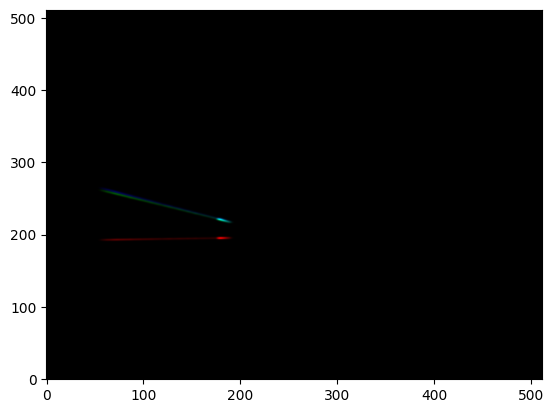

In [275]:
total=0
array=[]
arrayLab=[]

arrayOfBatches=[]
arrayOfLabels=[]

for batch_images, batch_labels in dataloader:
    # Iterate over each sample in the batch
    i=0
    for event, label in zip(batch_images, batch_labels):
        #print("batch: ",event.shape)
        #print("Label:", label.shape)
        #print("event in batch : ",event[i].shape)
        #print("Label:", label)
        array.append(event[i])
        arrayLab.append(label[i])
        i=i+1

    arrayOfBatches.append(array)
    arrayOfLabels.append(arrayLab)


##########################################################
##########################################################


print('====================')
print(' no entries        -> ',1000)
print(' no batches        -> ',batchSize)
print(' entries per batch -> ',1000/batchSize)
print('====================')
print( len(arrayOfLabels))  # should be the same as length of no of batches
print( len(arrayOfBatches)) # should be the same as length of no of batches
print('====================')
print( len(arrayOfLabels[0]))  # should be the same as length of no of entries per batches
print( len(arrayOfBatches[0])) # should be the same as length of no of entries per batches



batch    = 2
getEntry = 0
data = arrayOfBatches[batch][getEntry]

print('====================')

fig, axis = plt.subplots()
im = axis.imshow(data, origin='lower', aspect='auto')




# plot an entry

# load model

In [36]:



"""
merged_dataset = class1.concatenate(class2)
shuffled_dataset = merged_dataset.shuffle(buffer_size=2000)
train_ratio = 0.7

total_samples =2000
train_samples = int(train_ratio * total_samples)
test_samples = total_samples - train_samples

# Split the shuffled dataset into train and test
train_dataset = shuffled_dataset.take(train_samples)
valid_dataset = shuffled_dataset.skip(train_samples)


model_ft = models.resnet18(pretrained=True) # <------------------------------------------------------------

num_epochs = 10
batch_size = 10
learning_rate = 0.001
input_shape = (512, 512, 3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataloader = train_dataset.batch(batch_size)
valid_dataloader = valid_dataset.batch(batch_size)

num_ftrs = model_ft.fc.in_features

# initialise a fully connected layer with appropriate dimensions (num_ftrs x num_classes)
model_ft.fc = nn.Linear(num_ftrs, 2) # <------------------------------------------------------------
model_ft = model_ft.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# set the optimiser
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.90)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
"""

'\nmerged_dataset = class1.concatenate(class2)\nshuffled_dataset = merged_dataset.shuffle(buffer_size=2000)\ntrain_ratio = 0.7\n\ntotal_samples =2000\ntrain_samples = int(train_ratio * total_samples)\ntest_samples = total_samples - train_samples\n\n# Split the shuffled dataset into train and test\ntrain_dataset = shuffled_dataset.take(train_samples)\nvalid_dataset = shuffled_dataset.skip(train_samples)\n\n\nmodel_ft = models.resnet18(pretrained=True) # <------------------------------------------------------------\n\nnum_epochs = 10\nbatch_size = 10\nlearning_rate = 0.001\ninput_shape = (512, 512, 3)\n\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\n\ntrain_dataloader = train_dataset.batch(batch_size)\nvalid_dataloader = valid_dataset.batch(batch_size)\n\nnum_ftrs = model_ft.fc.in_features\n\n# initialise a fully connected layer with appropriate dimensions (num_ftrs x num_classes)\nmodel_ft.fc = nn.Linear(num_ftrs, 2) # <--------------------------------------

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += torch.sum(predicted == labels).item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = correct_predictions / len(train_dataset)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.4f}")

        model.eval()
        valid_loss = 0.0
        valid_correct_predictions = 0

        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                valid_correct_predictions += torch.sum(predicted == labels).item()

        valid_loss /= len(valid_dataset)
        valid_accuracy = valid_correct_predictions / len(valid_dataset)

        print(f"Validation Loss: {valid_loss:.4f} Validation Accuracy: {valid_accuracy:.4f}")
        print("-----------------------------------------")

        scheduler.step()

# Call the train_model function to start training
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs)


NameError: name 'model_ft' is not defined

In [ ]:
class1 = class1.shuffle(buffer_size=100)
class2 = class2.shuffle(buffer_size=100)

class1_count = len(list(class1))
class2_count = len(list(class2))

# Determine the number of samples for the train and test sets
train_count = int(0.7 * min(class1_count, class2_count))
test_count = int(0.3 * min(class1_count, class2_count))

# Take the desired number of samples from each class for train and test sets
train_class1 = class1.take(train_count)
train_class2 = class2.take(train_count)

test_class1 = class1.skip(train_count).take(test_count)
test_class2 = class2.skip(train_count).take(test_count)

# Concatenate the train datasets of both classes
train_dataset = train_class1.concatenate(train_class2)

# Concatenate the test datasets of both classes
test_dataset = test_class1.concatenate(test_class2)

# Shuffle the train dataset
train_dataset = train_dataset.shuffle(buffer_size=200)

TypeError: The dataset length is unknown.

In [ ]:
import uproot

file = uproot.open(path+filename1)

# Define the branch name
branch_name = "TPCData/Event/myChargeArray[3][3][256][512]"

# Iterate through the specified branch
for array in uproot.iterate(file[branch_name], step_size=batchSize, library="ak"):
    features = ak.to_numpy(array)


ValueError: cannot convert <RecordArray is_tuple='false' len='10'>
    <content index='0' field='myChargeArray[3][3][256][512]'>
        <RegularArray size='3' len='10'>
            <content><RegularArray size='3' len='30'>
                <content><RegularArray size='256' len='90'>
                    <content><RegularArray size='512' len='23040'>
                        <content><NumpyArray dtype='float32' len='11796480'>[0. 0. 0. ... 0. 0. 0.]</NumpyArray></content>
                    </RegularArray></content>
                </RegularArray></content>
            </RegularArray></content>
        </RegularArray>
    </content>
</RecordArray> into np.ndarray

This error occurred while calling

    ak.to_numpy(
        <Array [{...}, {...}, ..., {...}, {...}] type='10 * {"myChargeArray...'>
    )

In [ ]:
print(len(element))             # entries
print(len(element[0]))          # strips
print(len(element[0][0]))       # timebins
print(len(element[0][0][0]))    # channels

1
256
512
3


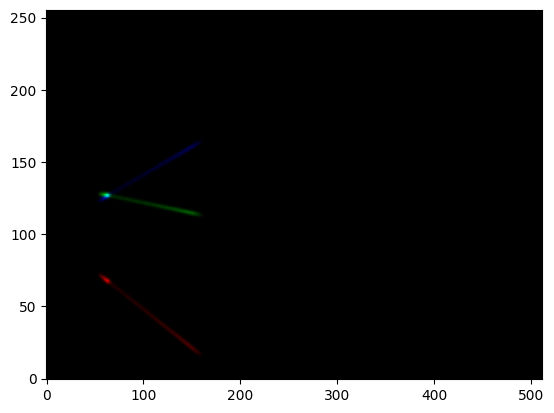

In [ ]:
event = 2

fig, axis = plt.subplots()
im = axis.imshow(element[0], origin='lower', aspect='auto')

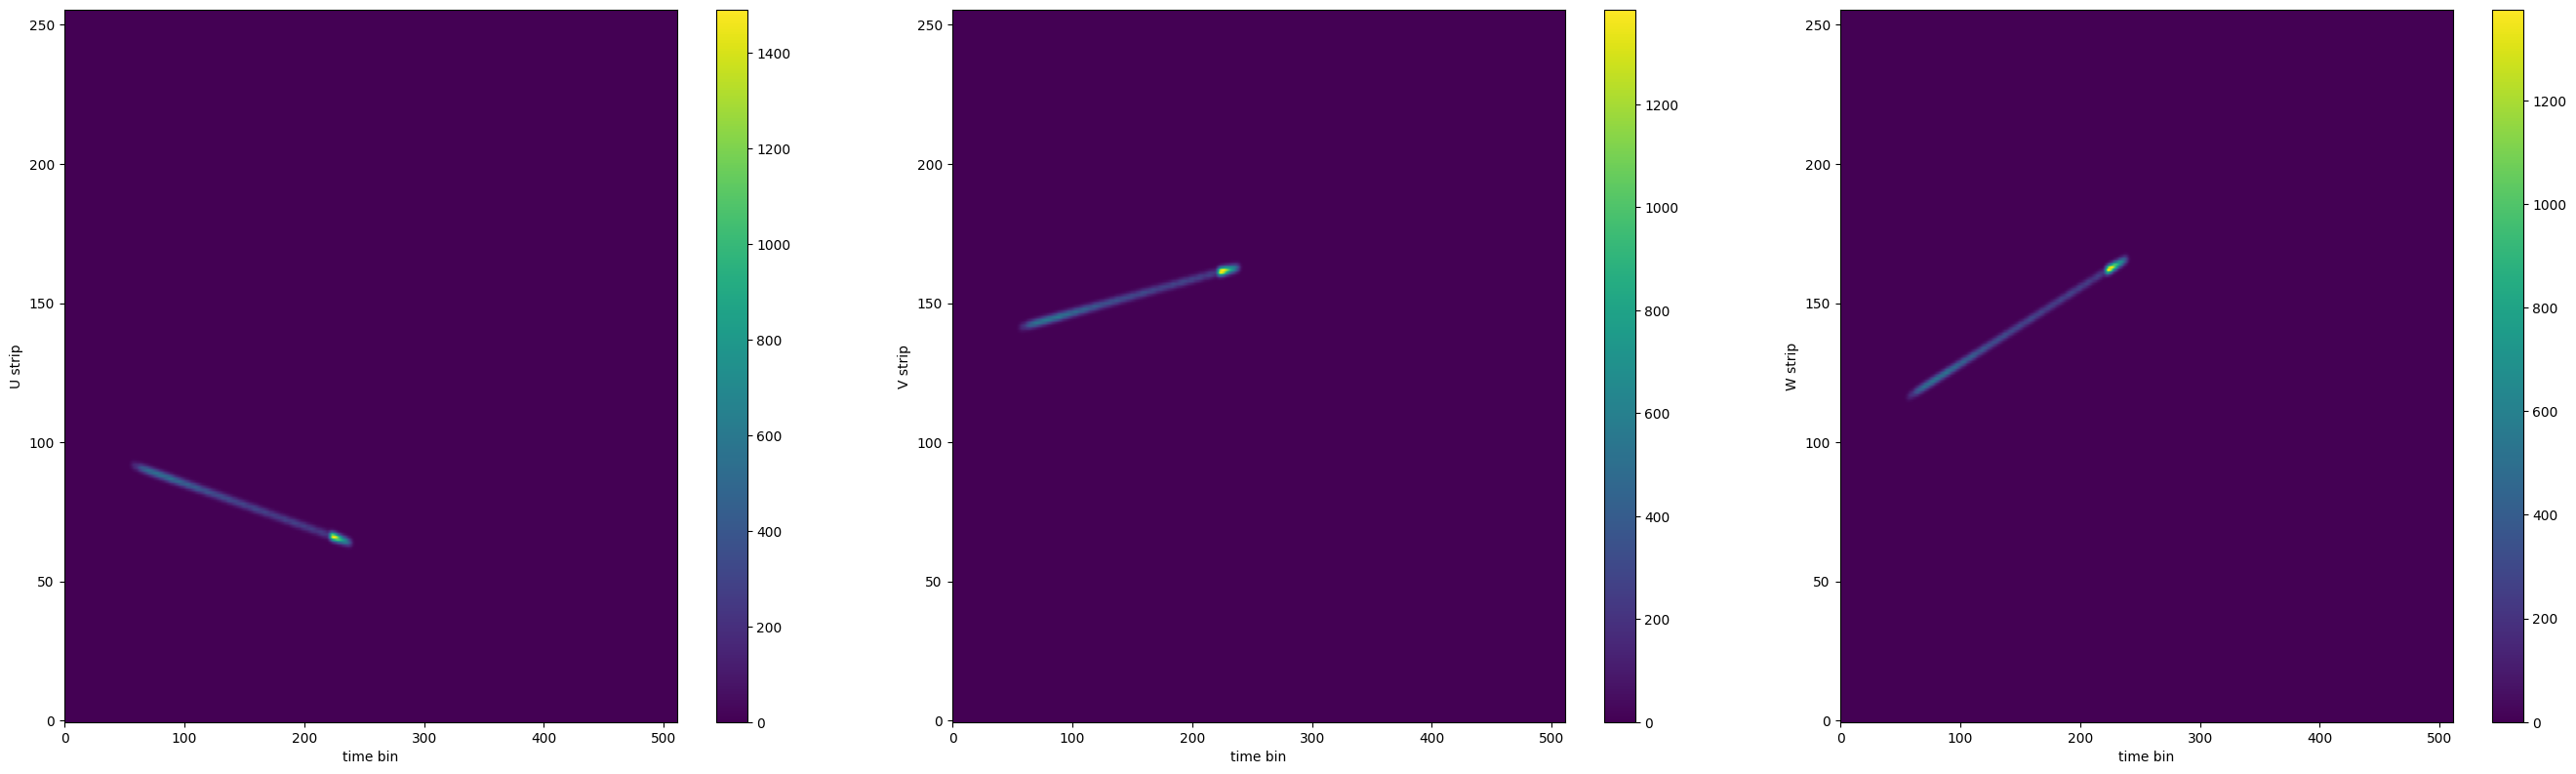

In [ ]:
projNames = ("U", "V", "W")
fig2, axes2 = plt.subplots(1,3, figsize=(28,10))
for strip in range(0,3):
    axis2 = axes2[strip] 
    data = element[1][:,:,strip]
    im2 = axis2.imshow(data, origin='lower', aspect='auto')    
    axis2.set_xlabel("time bin")
    axis2.set_ylabel(projNames[strip]+" strip")
    divider = make_axes_locatable(axis2)
    cax = divider.append_axes("right", size="5%", pad=0.4)
    fig2.colorbar(im2, cax=cax)
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)

In [30]:
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'
filename1 = 'THREE_ALPHA_BE+_1k_131MeV_250mbar_.root'
filename2 = 'C12_ALPHA_1k_131MeV_250mbar_.root'

#rootFile = uproot.open(path+filename1 + ':TPCData')
train_files = [path+filename1 + ':TPCData']

import TPCParser as io
importlib.reload(io)

# Define the generator function
def generator():
    for batch in io.generator(files=train_files, batchSize=2):
        yield batch


rain_dataset = tf.data.Dataset.from_generator(generator, output_signature=tf.TensorSpec(shape=(10, ), dtype=tf.float32))

# Iterate over the dataset and plot the images
for batch in rain_dataset:
    image_tensor = batch[0]  # Assuming the image tensor is the first element of the batch

2023-07-01 17:56:59.689283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-01 17:56:59.717916: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: AttributeError: module 'TPCParser' has no attribute 'generator'
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: module 'TPCParser' has no attribute 'generator'
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_7183/641164283.py", line 13, in generator
    for batch in io.generator(files=train_files, batchSize=2):

AttributeError: module 'TPCParser' has no attribute 'generator'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [ ]:
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'
filename1 = 'THREE_ALPHA_BE+_1k_131MeV_250mbar_.root'
data1 =  io.getDataML(path+filename1)
dataset = tf.data.Dataset.from_tensor_slices(data1,0)

: 

: 

In [ ]:
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'
filename2 = 'C12_ALPHA_1k_131MeV_250mbar_.root'
data2 =  io.getDataML(path+filename2)
dataset2 = tf.data.Dataset.from_tensor_slices(data2,1)


AttributeError: module 'skimage.io' has no attribute 'getDataML'

In [ ]:
import tensorflow as tf
import numpy as np

# Example arrays
images = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
labels = np.array([0, 1, 0])

# Create a dataset from arrays
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Create an iterator for the dataset
iterator = iter(dataset)

# Iterate over the dataset
for image, label in iterator:
    print(image, label)

tf.Tensor([1 2 3], shape=(3,), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)


2023-07-01 01:23:45.744856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3]
	 [[{{node Placeholder/_1}}]]


In [ ]:

# Concatenate the two datasets
concat_dataset = torch.utils.data.ConcatDataset([dataset, dataset2])

# Calculate the sizes for the train and validation sets
total_size = len(concat_dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(concat_dataset, [train_size, val_size])


num_classes = 2
resnet_model = models.resnet50(pretrained=True)

# Freeze the parameters of the pre-trained layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Define the criterion, optimizer, and transformation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False)





dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
iteratorTRAIN = iter(train_dataset)
iteratorVAL = iter(val_dataset)




In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    # start a timer
    since = time.time()

    # track the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # iterate over all epochs
    for epoch in range(num_epochs):
        
        # show the current epoch we are on
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in iteratorTRAIN:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass (track gradients if only in train mode)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # track the performance statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # step the learning rate scheduler if in train mode
            if phase == 'train':
                scheduler.step()
            
            # keep track of the overall loss and accuracy over each epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

            # keep a deep copy of the best performing model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # track the time taken
    time_elapsed = time.time() - since
    print(f'training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=8):
    
    # get the original model state
    was_training = model.training
    
    # switch it to eval mode (so we don't do the backwards pass)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # turn of gradient calculations
    with torch.no_grad():
        
        # get a batch of data
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            
            # move to the gpu / cpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # make a prediction
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # plot a number of images and the model predictions
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                # if we've plotted the desired number of images, 
                # switch the model back to it's original mode
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        # switch the model back to it's original mode
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True) # <------------------------------------------------------------
num_ftrs = model_ft.fc.in_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialise a fully connected layer with appropriate dimensions (num_ftrs x num_classes)
model_ft.fc = nn.Linear(num_ftrs, 4) # <------------------------------------------------------------
model_ft = model_ft.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# set the optimiser
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.90)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15);


Epoch 0/14
----------


TypeError: '_TensorSliceDataset' object is not subscriptable

In [ ]:
import TPCParser as io
importlib.reload(io)
###############################################
# <> PARSE DATA <> #
path = '/home/kris/Documents/coding/WAWTPC/krisTPCReco/TPCReco-kris/build/resources/'
filename1 = 'THREE_ALPHA_BE+_1k_131MeV_250mbar_.root:TPCData'
filename2 = 'C12_ALPHA_1k_131MeV_250mbar_.root'

train_files = [path+filename1]
            
datasetGenerator = partial(io.generator, files=train_files, batchSize=100)


train_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(100,) + (projections.shape), dtype=tf.float32),
    ))
#dataBeP = io.getDataML(path+filename1)
#dataC12 = io.getDataML(path+filename2)

for aBatch in train_dataset.take(1):
   
    pass


2023-07-01 00:51:11.204901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-01 00:51:11.300015: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: CannotBeAwkward: SimHit
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kris/Documents/coding/WAWTPC

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} CannotBeAwkward: SimHit
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kris/Documents/coding/WAWTPC/ML/MachineLearningTPC/MachineLearning/WAWTPC/classification/TPCParser.py", line 178, in generator
    for array in uproot.iterate(files, step_size=batchSize,

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 193, in iterate
    for item in hasbranches.iterate(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 1080, in iterate
    _ranges_or_baskets_to_arrays(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/behaviors/TBranch.py", line 3041, in _ranges_or_baskets_to_arrays
    arrays[cache_key] = interpretation.final_array(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/objects.py", line 423, in final_array
    output = library.finalize(

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/library.py", line 572, in finalize
    interpretation.awkward_form(interpretation.branch.file).to_json()

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/interpretation/objects.py", line 113, in awkward_form
    return self._model.awkward_form(self._branch.file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/containers.py", line 691, in awkward_form
    values_form = uproot._util.awkward_form(self._values, file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/_util.py", line 587, in awkward_form
    return model.awkward_form(file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/containers.py", line 1063, in awkward_form
    uproot._util.awkward_form(self._values, file, context),

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/_util.py", line 587, in awkward_form
    return model.awkward_form(file, context)

  File "/home/kris/.local/lib/python3.10/site-packages/uproot/model.py", line 686, in awkward_form
    raise uproot.interpretation.objects.CannotBeAwkward(

uproot.interpretation.objects.CannotBeAwkward: SimHit


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [ ]:
import TPCParser as io
import importlib
import tensorflow as tf

importlib.reload(io)

def generator_wrapper():
    generator = io.getDataMLGenerator(path + filename1, batch_size=100)
    for data in generator:
        yield data

train_dataset = tf.data.Dataset.from_generator(
    generator_wrapper,
    output_signature=tf.TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32)
)

for batch_data in train_dataset.take(1):
    print(batch_data)


2023-07-01 00:05:06.796271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-01 00:05:15.910875: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in genera

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

2023-07-01 00:05:17.557835: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.
Traceback (most recent call last):

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/kris/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (100, 3, 3, 512, 3) where an element of shape (None, 512, 512, 3) was expected.


2023-07-01 00:05:17.557930: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start abort

## Training Dataset preparation

In [ ]:
num_classes = 3
resnet_model = models.resnet50(pretrained=True)

# Freeze the early layers
for param in resnet_model.parameters():
    param.requires_grad = False


    

/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
